## Background
This project will explore various density estimation methods. The first part will go over different density estimations in 1D and the second part will try to obtain the optimal hyperparameters.

## 1.1 - Gaussian density

In [ ]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
np.random.seed(42)
class GaussianDensity(BaseEstimator):
    def fit(self, X, y=None):
        self.mean_ = np.mean(X)
        self.std_ = np.std(X)
        return self

    def predict_proba(self, X):
        pdf_values = scipy.stats.norm.pdf(X, loc=self.mean_, scale=self.std_)
        return pdf_values

## 1.2 - Histogram density

In [ ]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
np.random.seed(42)
class HistogramDensity(BaseEstimator):
    def __init__(self, n_bins, min_val, max_val):
        self.n_bins = n_bins
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        self.bin_edges_ = np.linspace(self.min_val, self.max_val, self.n_bins+1)
        self.pdf_per_bin_ = np.zeros(self.n_bins)
        for i in range(self.n_bins):
            self.pdf_per_bin_[i] = np.sum((X >= self.bin_edges_[i]) & (X < self.bin_edges_[i+1])) / len(X) / (self.bin_edges_[i+1] - self.bin_edges_[i])
        return self

    def predict_proba(self, X):
        pdf_values = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X[i] < self.min_val or X[i] > self.max_val:
                pdf_values[i] = 0
            else:
                for j in range(self.n_bins):
                    if X[i] >= self.bin_edges_[j] and X[i] < self.bin_edges_[j+1]:
                        pdf_values[i] = self.pdf_per_bin_[j]
                        break

        return pdf_values

## 1.3 - Kernel density
Gaussian kernel density is given by:
$$p(x; \mathcal{D}) = \frac{1}{n}\sum_{i=1}^n p_{\mathcal{N}}(x; \mu = x_i, \sigma=h) $$
where $\mathcal{D}=\{x_i\}_{i=1}^n$ is a training dataset of $n$ samples, $p_{\mathcal{N}}$ is the Gaussian/normal density function and $h$ is called the bandwidth hyperparameter of the KDE model.

In [ ]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
np.random.seed(42)
class KernelDensity(BaseEstimator):
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth

    def fit(self, X, y=None):
        # Save the training data in self.X_train_
        self.X_train_ = X
        return self

    def predict_proba(self, X):
        pdf_values = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pdf_values[i] = np.mean(scipy.stats.norm.pdf(X[i], loc=self.X_train_, scale=self.bandwidth))
        return pdf_values 

(200, 1) (200, 1)
Fitting GaussianDensity model
False, Shape=(1000, 1) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=0.9999916379946465

Fitting HistogramDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0000260507608276

Fitting KernelDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0



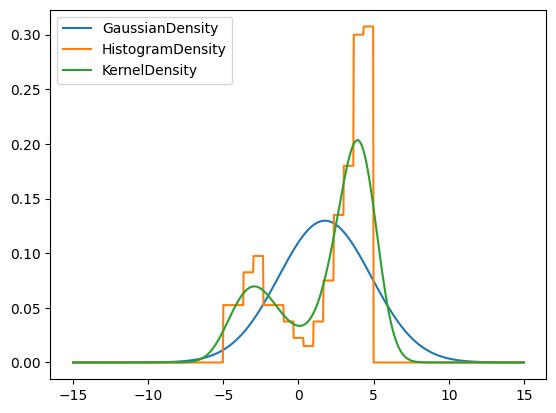

In [ ]:
# %pdb on
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Generate some data and split into train and test
np.random.seed(42)
min_val, max_val = -5, 5
diff = max_val - min_val
X = diff * np.vstack([scipy.stats.beta(6,1).rvs(size=(300,1)), scipy.stats.beta(2,7).rvs(size=(100,1))]) - diff/2
X_train, X_test = train_test_split(X, test_size=0.5, random_state=15)
print(X_train.shape, X_test.shape)

# Loop through models
models = [GaussianDensity(),
          HistogramDensity(n_bins=15, min_val=min_val, max_val=max_val),
          KernelDensity(bandwidth=1)
         ]
for model in models:
    print(f'Fitting {type(model).__name__} model')
    # Fit models
    model.fit(X_train)

    # Sanity checks
    xq = np.linspace(min_val-diff, max_val+diff, num=1000)
    pdf_vals = model.predict_proba(xq.reshape(-1, 1))
    # Check that right size and >= 0
    print(f'{len(pdf_vals.shape) == 1 and pdf_vals.shape[0] == len(xq)}, Shape={pdf_vals.shape}'
          f' - Is the output the correct shape?')
    print(f'{np.all(pdf_vals>=0)}, Num neg={np.sum(pdf_vals < 0)} - Are all pdf values >= 0? ')

    # Check that integrates to 1 vai approximate numerical integration
    model_pdf = lambda x: model.predict_proba(np.array(x).reshape(1,1))[0]
    quad_out = scipy.integrate.quad(model_pdf, min_val - diff, max_val + diff, limit=100, full_output=True)
    # print(f'{np.abs(quad_out[0] - 1) < 1e-4}, quad_out={quad_out[0]} - Does the PDF integrate to 1? ')
    print(f'quad_out={quad_out[0]}')
    print('')

    # Plot density model
    plt.plot(xq, pdf_vals, label=type(model).__name__)

plt.legend()

## 2.1 - Implement custom scorer function for use in GridSearchCV
This section will implement a `scorer` function that will compute the log likelihood of the data given (higher is better).
This function takes in the model, the input data X and y_true (which defaults to None since this is an unsupervised problem and can be ignored).

In [ ]:
def mean_log_likelihood_scorer(model, X, y_true=None, lam=1e-15):
    #  (Note y_true is not used)
    mean_log_val = np.mean(np.log(model.predict_proba(X) + lam))
    return mean_log_val

## 2.2 - Estimate best hyperparameters
The `estimate_param` function takes in the density model, train and test dataset, parameter searching grid, model evaluation function and the number of folds for cross validaiton, and outputs the grid search result and the score on the test dataset. It uses sklearn's cross validation utilities to cross validate using the training data to determine the best parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

def estimate_param(X_train, X_test, density_model, param_grid, score_function, cv):
  """
  Complete this function by using the GridSearchCV to search for the best parameter within the grid
  Inputs:
    X_train: training data
    X_test: testing data
    density_model: the density estimation function
    param_grid: a dictionary of the searching grid
    score_function: a function that evaluates the model on a dataset
    cv: number of folds for cross validation
  Output:
    grid_search_cv: the estimator after fitting on the training data
    test_log_likelihood: the log-likelihood of test set using the best number of bins
  """
  grid_search_cv = GridSearchCV(density_model, param_grid, scoring=score_function, cv=cv)
  grid_search_cv.fit(X_train)
  test_log_likelihood = mean_log_likelihood_scorer(grid_search_cv.best_estimator_, X_test)
  return grid_search_cv, test_log_likelihood

# Call the estimation function with the desired parameters and extract the best number of bins selected by CV
np.random.seed(42) 
param_grid = {'n_bins': np.arange(1, 50)}
density_model = HistogramDensity(n_bins=15, min_val=min_val, max_val=max_val)
cv = 10
grid_search_cv, test_log_likelihood = estimate_param(X_train, X_test, density_model, param_grid, mean_log_likelihood_scorer, cv)
best_n_bins = grid_search_cv.best_params_['n_bins']

print(f"The best parameter given for n_bins is {best_n_bins}")
print(f"Log-likelihood for test data is {test_log_likelihood}")

The best parameter given for n_bins is 6
Log-likelihood for test data is -1.8869764537763678


In [ ]:
# Call the estimation function with the desired parameters and extract the best bandwidth as selected by CV
np.random.seed(42)

param_grid = {'bandwidth': np.linspace(0.1, 10, 50)}
density_model = KernelDensity(bandwidth=1)
cv = 10
grid_search_cv, test_log_likelihood = estimate_param(X_train, X_test, density_model, param_grid, mean_log_likelihood_scorer, cv)
best_bandwidth = grid_search_cv.best_params_['bandwidth']

print(f"The best parameter given for bandwidth is {best_bandwidth}")
print(f"Log-likelihood for test data is {test_log_likelihood}")

The best parameter given for bandwidth is 0.3020408163265306
Log-likelihood for test data is -1.9436632867557386
